In [2]:
import numpy as np
import astropy.io.fits
import scipy
import sklearn.ensemble
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,RidgeClassifier,SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

#Overview of the dataset

hdulist = fits.open('osc-ned+phot+spec.fits')
cols = hdulist[1].columns
print (len(cols.names))
print (len(hdulist[1].data))
print cols

#print SN types and numbers

sn_type_dict = {}
for i in range(len(hdulist[1].data)):
    if hdulist[1].data[i][7] in sn_type_dict:
        sn_type_dict[hdulist[1].data[i][7]] += 1
    else:
        sn_type_dict[hdulist[1].data[i][7]] = 1
        
print sn_type_dict

66
15550
ColDefs(
    name = 'Name'; format = '64A'
    name = 'Disc. Date'; format = '64A'
    name = 'mmax'; format = 'D'
    name = 'Host Name'; format = '64A'
    name = 'R.A.'; format = '128A'
    name = 'Dec.'; format = '128A'
    name = 'z'; format = '64A'
    name = 'Type'; format = '32A'
    name = 'Phot.'; format = 'D'
    name = 'Spec.'; format = 'D'
    name = 'Radio'; format = 'D'
    name = 'X-ray'; format = 'D'
    name = 'ned_searched'; format = 'D'
    name = 'ned_identifier'; format = '36A'
    name = '2MASS_Ks'; format = 'D'
    name = '2MASS_Ks_Err'; format = 'D'
    name = '2MASS_J'; format = 'D'
    name = '2MASS_J_Err'; format = 'D'
    name = '2NASS_H'; format = 'D'
    name = '2NASS_H_Err'; format = 'D'
    name = 'SDSS_u'; format = 'D'
    name = 'SDSS_u_Err'; format = 'D'
    name = 'SDSS_g'; format = 'D'
    name = 'SDSS_g_Err'; format = 'D'
    name = 'SDSS_r'; format = 'D'
    name = 'SDSS_r_Err'; format = 'D'
    name = 'SDSS_i'; format = 'D'
    name = '

In [3]:

#show how many "nan"s (out of 15550)for each feature 
nan_type_number = {}

for j in range(len(cols.names)):
    k=0
    for i in range(len(hdulist[1].data)):
        if str(hdulist[1].data[i][j]) == 'nan':
            k += 1 
    nan_type_number[cols.names[j]] = k
print nan_type_number


{'2NASS_H_Err': 15550, 'SDSS_g_Err': 8901, 'MPA-JHU_Halpha': 12815, 'WiscPCA_src': 12228, 'IRAS_60m_Err': 11529, 'IRAS_100m_Err': 12192, 'MPA-JHU_logSpecSFR_p50': 12815, 'IRAS_12m_Err': 13153, 'Disc. Date': 1865, 'SDSS_i_Err': 8901, 'Type': 7945, 'SDSS_z': 8901, 'Host_Dec': 0, 'Spec.': 12855, 'mmax': 2489, 'Dec.': 15, 'WiscPCA_StellarSigma': 12904, 'ned_searched': 0, 'Phot.': 2167, 'GALEX_FUV_Err': 9196, 'MPA-JHU_logMstar_p50': 12815, 'R.A.': 15, '2MASS_J_Err': 8800, 'GALEX_NUV_Err': 8993, '2MASS_J': 8800, 'Firefly_Chabrier_MILES_Mstar': 12807, 'IRAS_25m_Err': 14282, 'SDSS_FiberID': 0, 'SDSS_u_Err': 8901, 'IRAS_12m': 13152, 'Firefly_Chabrier_MILES_Metallicity_LightWt': 12807, 'MPA-JHU_OH_p50': 12815, 'Host_z': 6337, 'IRAS_25m': 14280, 'Name': 0, 'SDSS_g': 8901, 'SDSS_i': 8901, 'IRAS_60m': 11529, 'MPA-JHU_D4000': 12815, 'Firefly_Chabrier_MILES_spm_EBV': 12807, 'GALEX_NUV': 8993, 'SDSS_r': 8901, 'SDSS_u': 8901, 'IRAS_100m': 12192, 'SDSS_SpecMatched': 0, 'SDSS_r_Err': 8901, 'ned_identifie

In [36]:
sn_data = hdulist[1].data
#sn_type_number = {'Ia': 0, 'Ia-91T': 1, 'Ia-91bg': 2, 'Ca rich': 3,
#'Ia-02cx':4, 'Ia-csm': 5, 'IIP':6, 'IIn': 7, 'Ib': 8, 'Ic': 9,
#'Ic-BL': 10, 'SLSN-II': 11, 'SLSN-I': 12, 'LGRB': 13}

sdss_u = hdulist[1].data['SDSS_u']
sdss_g = hdulist[1].data['SDSS_g']
sdss_r = hdulist[1].data['SDSS_r']
sdss_i = hdulist[1].data['SDSS_i']
sdss_z = hdulist[1].data['SDSS_z']
galex_nuv = hdulist[1].data['GALEX_NUV']
galex_fuv = hdulist[1].data['GALEX_FUV']
firefly_chabrier_MILES_age_lightwt = hdulist[1].data['Firefly_Chabrier_MILES_Age_LightWt']
firefly_chabrier_MILES_metallicity_lightwt = hdulist[1].data['Firefly_Chabrier_MILES_Metallicity_LightWt']
firefly_chabrier_MILES_mstar = hdulist[1].data['Firefly_Chabrier_MILES_Mstar']
firefly_chabrier_MILES_spm_ebv = hdulist[1].data['Firefly_Chabrier_MILES_spm_EBV']

map_array = []


sdss_u_filtered=[]
sdss_g_filtered=[]
sdss_r_filtered=[]
sdss_i_filtered=[]
sdss_z_filtered=[]
galex_nuv_filtered=[]
galex_fuv_filtered=[]


array_0 = ['nIa', 'Ia', 'Ia*', 'Ia-HV']
array_1 = ['Ia-91T']
array_2 = ['Ia-91bg']
array_3 = ['IIb/Ib/Ic (Ca rich)', 'Ib/Ic (Ca rich)', 'Ib (Ca rich)']
array_4 = ['Ia CSM']
array_5 = ['Ia-02cx', 'Iax[02cx-like]']
array_6 = ['II P', 'II-p', 'II Pec', 'II P Pec', 'II?', 'II Pec?', 'IIP?', 'II']
array_7 = ['IIn', 'IIn Pec', 'LBV to IIn', 'IIn-pec/LBV', 'IIn?']
array_8 = ['Ib', 'Ibn']
array_9 = ['Ic?', 'Ic-lum?', 'Ic Pec', 'Ic']
array_10 = ['BL-Ic', 'Ic BL']
array_11 = ['SLSN-II?', ]
array_12 = ['SLSN-I']
array_13 = ['LGRB']

SN_array=[array_0,array_1,array_2,array_3,array_4,array_5,array_6,array_7,
          array_8,array_9,array_10,array_11,array_12,array_13]

for i in range(len(sn_data)):
    if (str(sdss_u[i]) != 'nan' and str(sdss_g[i]) != 'nan' and str(sdss_r[i]) != 'nan' 
    and str(sdss_i[i]) != 'nan' and str(sdss_z[i])!= 'nan' and str(galex_nuv[i]) != 'nan' 
    and str(galex_fuv[i]) !='nan'): 
        for k in range(len(SN_array)):
            if sn_data[i][7] in SN_array[k]:
                map_array.append(k)
                sdss_u_filtered.append(sdss_u[i])
                sdss_g_filtered.append(sdss_g[i])
                sdss_r_filtered.append(sdss_r[i])
                sdss_i_filtered.append(sdss_i[i])
                sdss_z_filtered.append(sdss_z[i])
                galex_nuv_filtered.append(galex_nuv[i])
                galex_fuv_filtered.append(galex_fuv[i])

print(len(map_array))
print map_array


#Shuffle the data:
import random
map_array_random = random.sample(map_array, len(map_array))

#Create uniformly distributed 'fake' data:
random_SN = []
while True:
    for i in range(len(SN_array)):
        random_SN.append(i)
    if len(random_SN) >= len(map_array):
        break
random.shuffle(random_SN)


1022
[8, 0, 0, 0, 0, 0, 8, 0, 0, 5, 0, 9, 0, 0, 0, 0, 0, 7, 9, 0, 7, 6, 0, 8, 0, 0, 0, 0, 6, 0, 0, 0, 8, 0, 7, 6, 0, 5, 0, 0, 6, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 6, 9, 0, 0, 0, 6, 6, 6, 6, 0, 6, 6, 0, 0, 6, 6, 7, 6, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0, 6, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 7, 6, 0, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 0, 0, 0, 6, 6, 6, 0, 6, 0, 6, 0, 6, 0, 6, 6, 6, 0, 0, 6, 6, 0, 0, 0, 0, 0, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 2, 6, 6, 6, 0, 0, 0, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 2, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 6, 0, 0, 6, 6, 6, 0, 0, 7, 0, 6, 0, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0, 8, 0, 6, 6, 6, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 6, 0, 0, 6, 0, 6, 6, 6, 6, 6, 5, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6

In [29]:
#Define features:
features = [np.array(sdss_u_filtered)-np.array(sdss_g_filtered),
np.array(sdss_g_filtered)-np.array(sdss_r_filtered),
np.array(sdss_r_filtered)-np.array(sdss_i_filtered),
np.array(sdss_i_filtered)-np.array(sdss_z_filtered),
np.array(galex_nuv_filtered)-np.array(sdss_u_filtered),
np.array(galex_fuv_filtered)-np.array(galex_nuv_filtered)]


#Define X and y for the classifiers

X = np.vstack(features).T
y = np.array(map_array).astype(int)
y_random = np.array(map_array_random).astype(int)
y_random2 = np.array(random_SN).astype(int)

print features

[array([ 1.656,  1.773,  1.954, ...,  1.592,  1.993,  1.104]), array([ 0.77 ,  0.773,  1.112, ...,  0.711,  0.893,  0.341]), array([ 0.397,  0.4  ,  0.746, ...,  0.374,  0.432,  0.253]), array([ 0.185,  0.332,  0.301, ...,  0.279,  0.334,  0.135]), array([ 5.8311,  5.6924,  4.0079, ...,  2.4013,  3.0106,  1.5707]), array([ 2.1935,  1.2904,  0.3505, ...,  0.5154,  0.3049,  0.2928])]


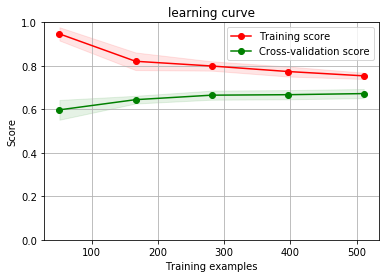

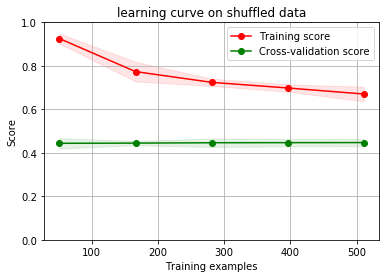

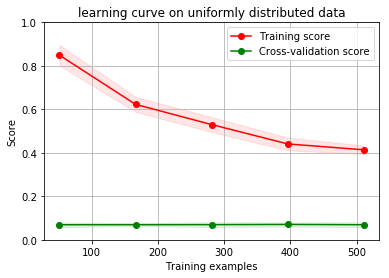

In [19]:
#Plot learning curve:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
estimator = RandomForestClassifier(max_depth = 5)
plot_learning_curve(estimator, "learning curve", X, y, (0, 1), cv=cv, n_jobs=4)
plot_learning_curve(estimator, "learning curve on shuffled data", X, y_random, (0, 1), cv=cv, n_jobs=4)
plot_learning_curve(estimator, "learning curve on uniformly distributed data", X, y_random2, (0, 1), cv=cv, n_jobs=4)


plt.show()

In Chapter 8, Section 11; the training error and cross-validation error behaves as follows:
- If the training error and cross-validation error have converged, then adding more training samples does not make any improvements.  This indicates the modeling having high bias. High-bias can be corrected by the following approaches:
    - Add more features to the data
    - Increase the model complexity
    - Decrease the regularization


- If the training error is much smaller than the cross-validation error, then increasing training samples will improve the model. This indicates a model with high variance. High-variance can be corrected by the following approaches:
    - Increase size of training set
    - Decrease the model complexity
    - Increase amplitude of regularization


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):

             precision    recall  f1-score   support

          0       0.59      0.86      0.70       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.76      0.54      0.63       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.62      0.64      0.61       511

(0.61695444991242776, 0.64383561643835607, 0.6102472215182464)


/Users/runlyt/anaconda/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/runlyt/anaconda/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/User

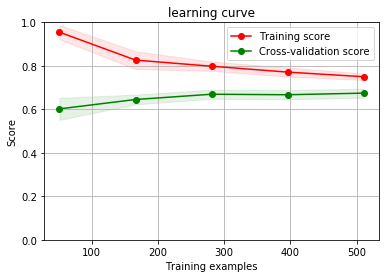

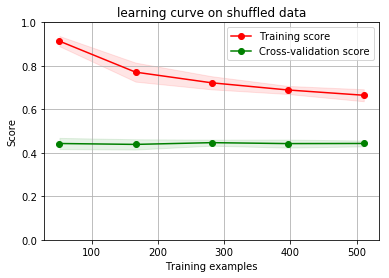

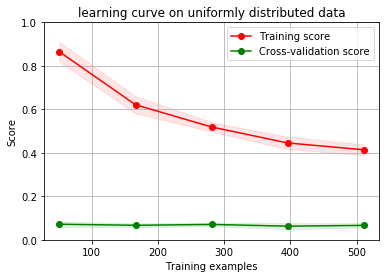


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):

             precision    recall  f1-score   support

          0       0.60      0.73      0.66       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.68      0.65      0.66       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.59      0.63      0.61       511

(0.5858614456519371, 0.63405088062622306, 0.60693037724640253)


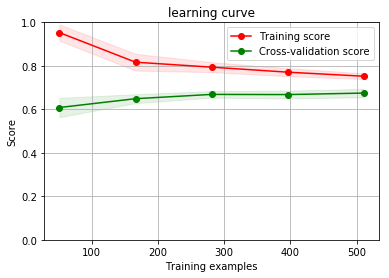

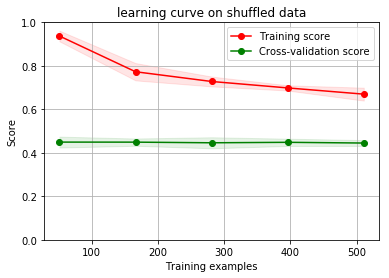

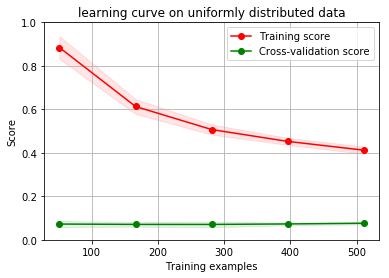


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False):

             precision    recall  f1-score   support

          0       0.67      0.72      0.69       238
          1       0.00      0.00      0.00         3
          2       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         2
          6       0.67      0.69      0.68       231
          7       0.00      0.00      0.00         9
          8       0.25      0.07      0.11        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00      

/Users/runlyt/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


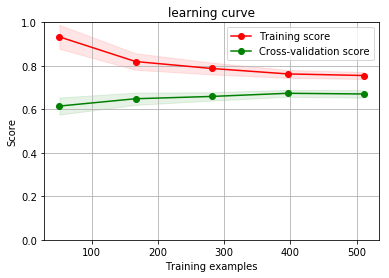

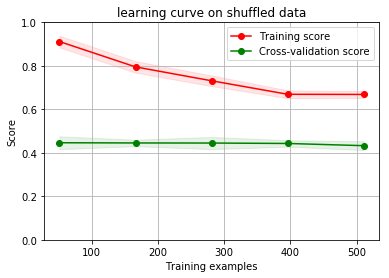

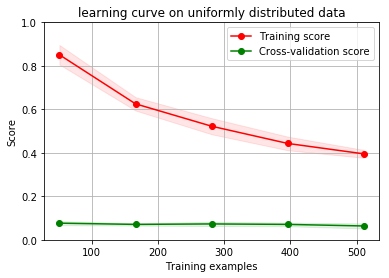


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):

             precision    recall  f1-score   support

          0       0.64      0.69      0.66       238
          1       0.00      0.00      0.00         3
          2       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         2
          6       0.64      0.67      0.65       231
          7       0.00      0.00      0.00         9
          8       0.25      0.07      0.11        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.59      0.63      0.61  

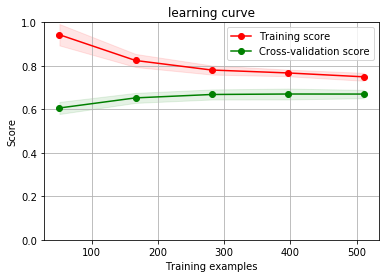

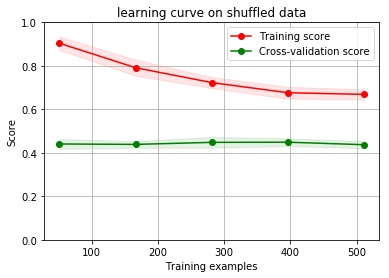

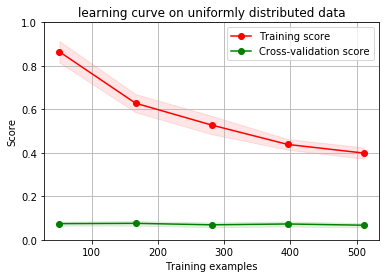


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None):

             precision    recall  f1-score   support

          0       0.62      0.80      0.70       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.72      0.64      0.68       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.61      0.66      0.63       511

(0.61466544792005351, 0.65949119373776899, 0.63038140236549434)


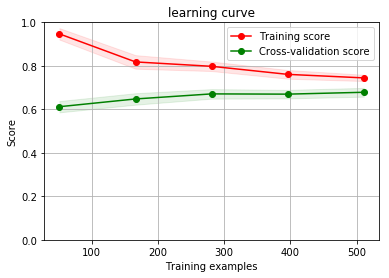

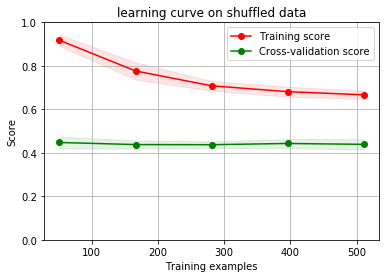

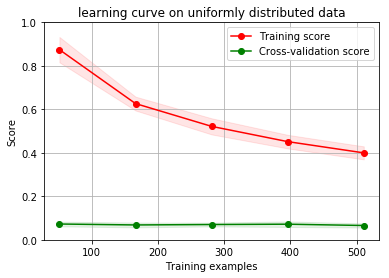


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False):

             precision    recall  f1-score   support

          0       0.66      0.76      0.71       238
          1       0.00      0.00      0.00         3
          2       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         2
          6       0.71      0.69      0.70       231
          7       0.00      0.00      0.00         9
          8       0.25      0.07      0.11        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.64      0.67      0.65       511

(0.63759

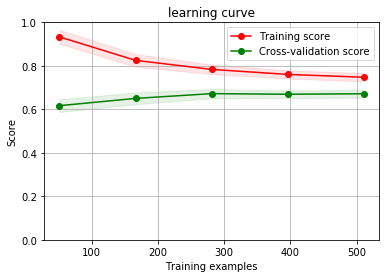

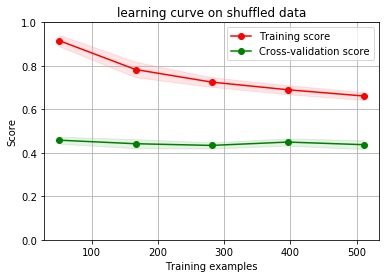

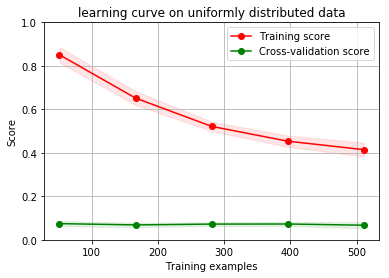


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'):

             precision    recall  f1-score   support

          0       0.60      0.77      0.68       238
          1       0.00      0.00      0.00         3
          2       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         2
          6       0.69      0.61      0.64       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.59      0.63      0.61       511

(0.59153030532706774, 0.6320939334637965, 0.60607161286548372)


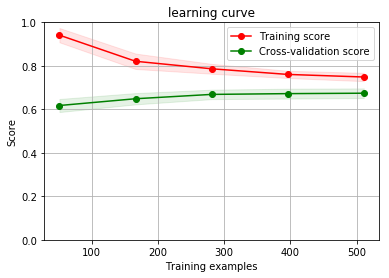

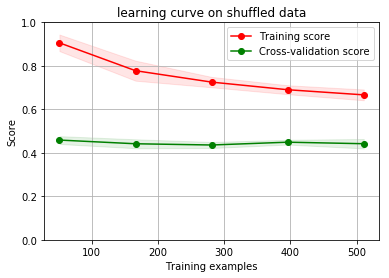

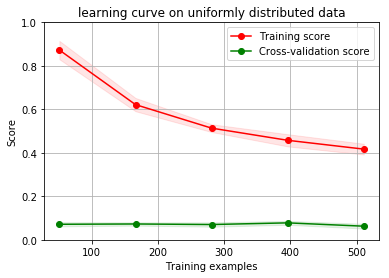


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):

             precision    recall  f1-score   support

          0       0.59      0.73      0.65       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.67      0.63      0.65       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.58      0.62      0.60       511

(0.57775346240307868, 0.62426614481409004, 0.59747191932793364)


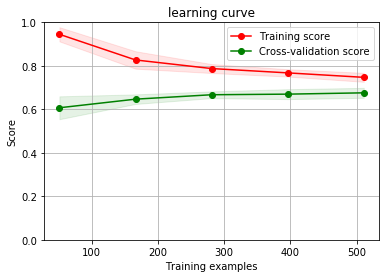

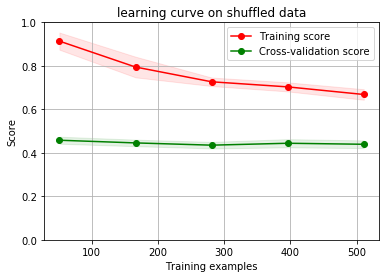

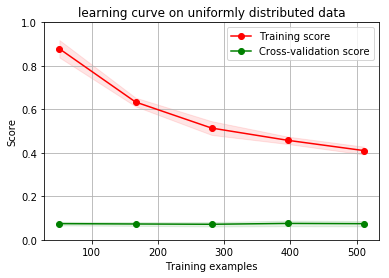


PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=5, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False):

             precision    recall  f1-score   support

          0       0.57      0.76      0.65       238
          1       0.00      0.00      0.00         3
          2       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         2
          6       0.67      0.55      0.61       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.57      0.60      0.58       511

(0.57047709806472446, 0.60469667318982379, 0.57867239575501062)


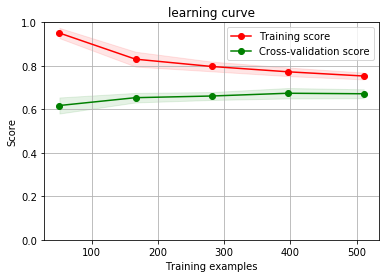

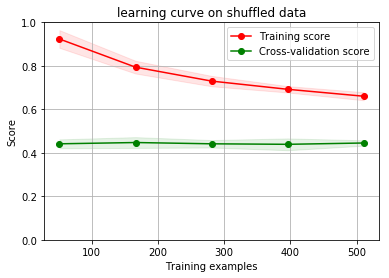

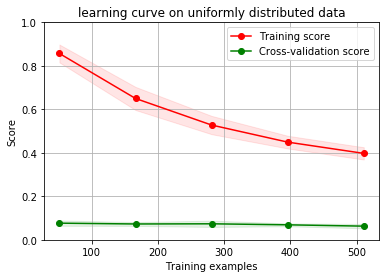


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001):

             precision    recall  f1-score   support

          0       0.60      0.71      0.65       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.66      0.66      0.66       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.58      0.63      0.60       511

(0.57720681900555104, 0.6262230919765166, 0.59962943808185853)


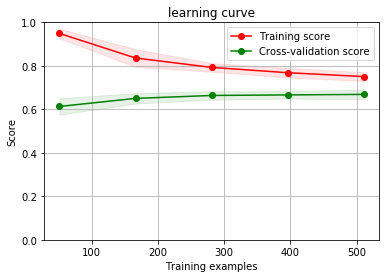

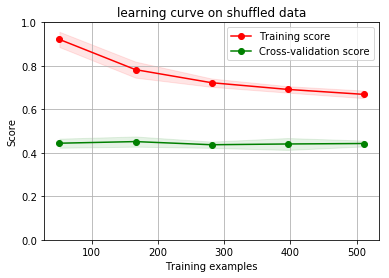

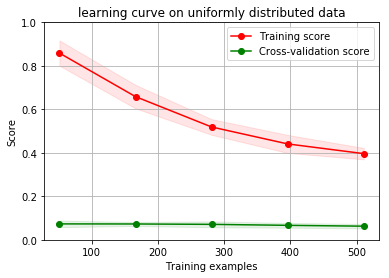


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False):

             precision    recall  f1-score   support

          0       0.60      0.85      0.70       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.76      0.56      0.64       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.62      0.65      0.62       511

(0.62193230789709508, 0.64970645792563597, 0.61857073562147669)


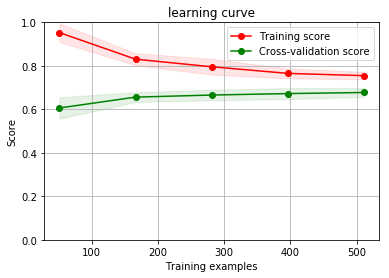

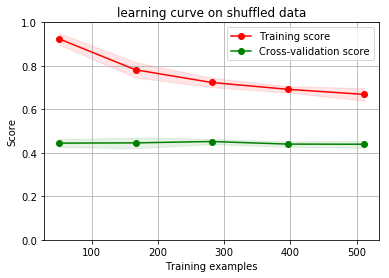

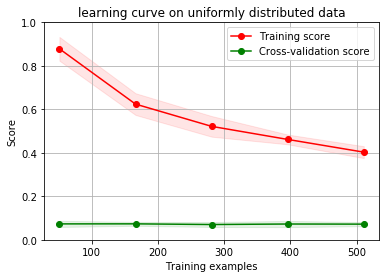


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False):

             precision    recall  f1-score   support

          0       0.61      0.84      0.71       238
          1       0.00      0.00      0.00         3
          5       0.00      0.00      0.00         2
          6       0.75      0.59      0.66       231
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00        15
          9       0.00      0.00      0.00        11
         13       0.00      0.00      0.00         2

avg / total       0.62      0.66      0.63       511

(0.62093196806108497, 0.657534

/Users/runlyt/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


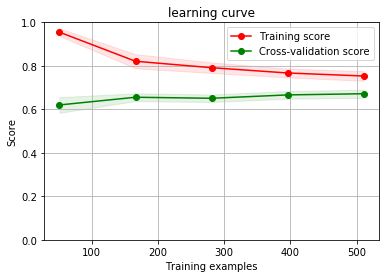

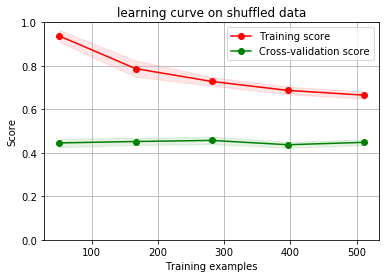

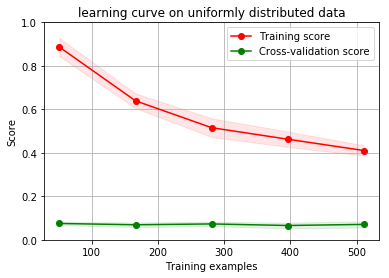

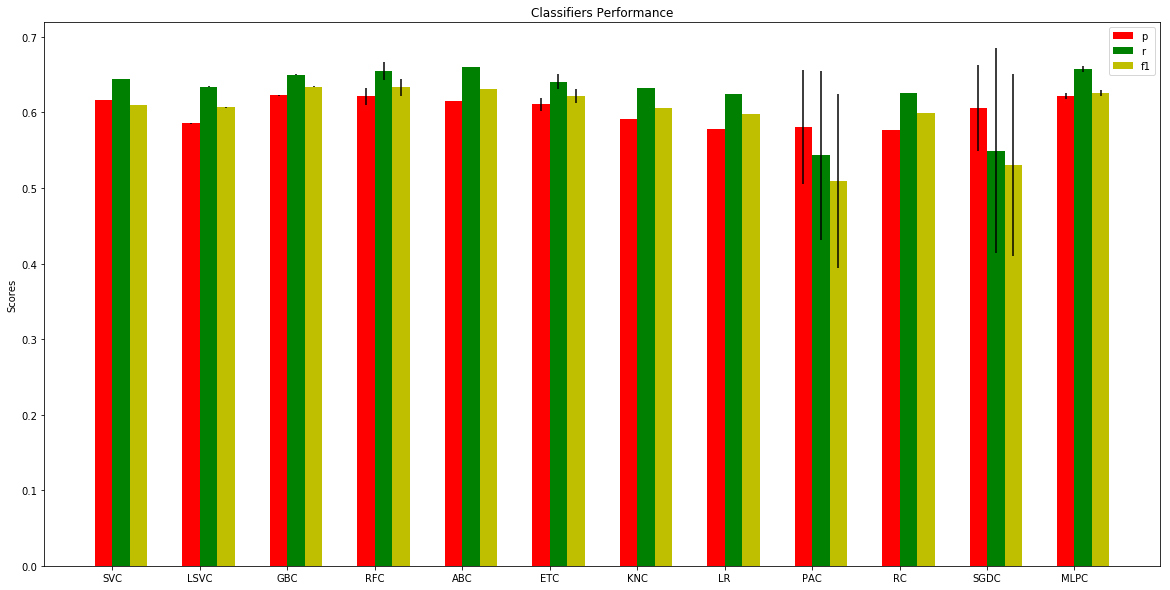

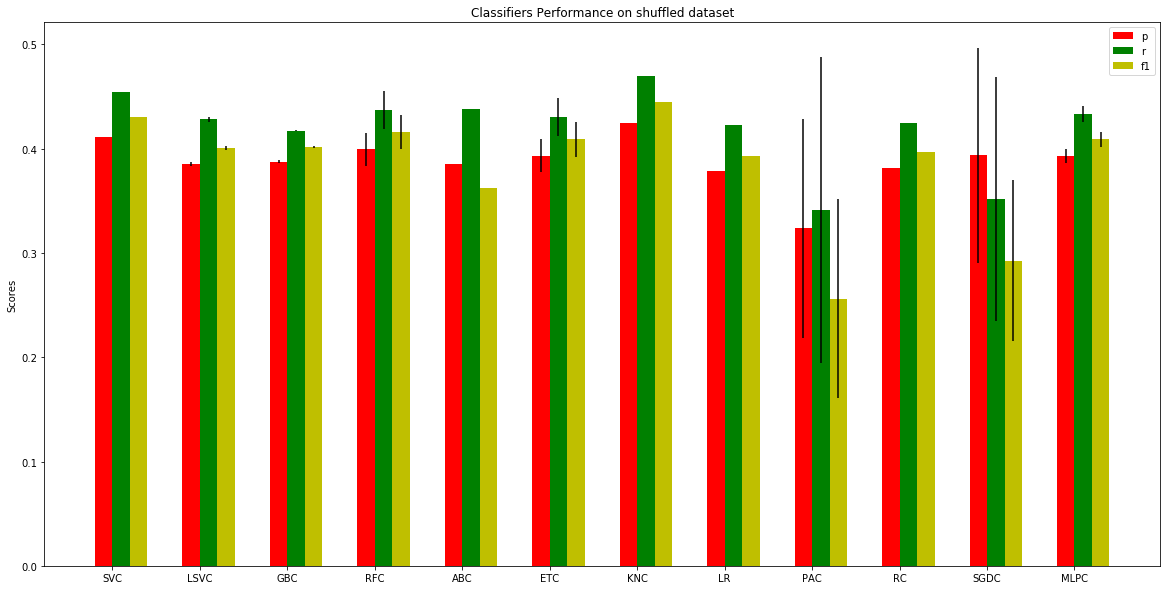

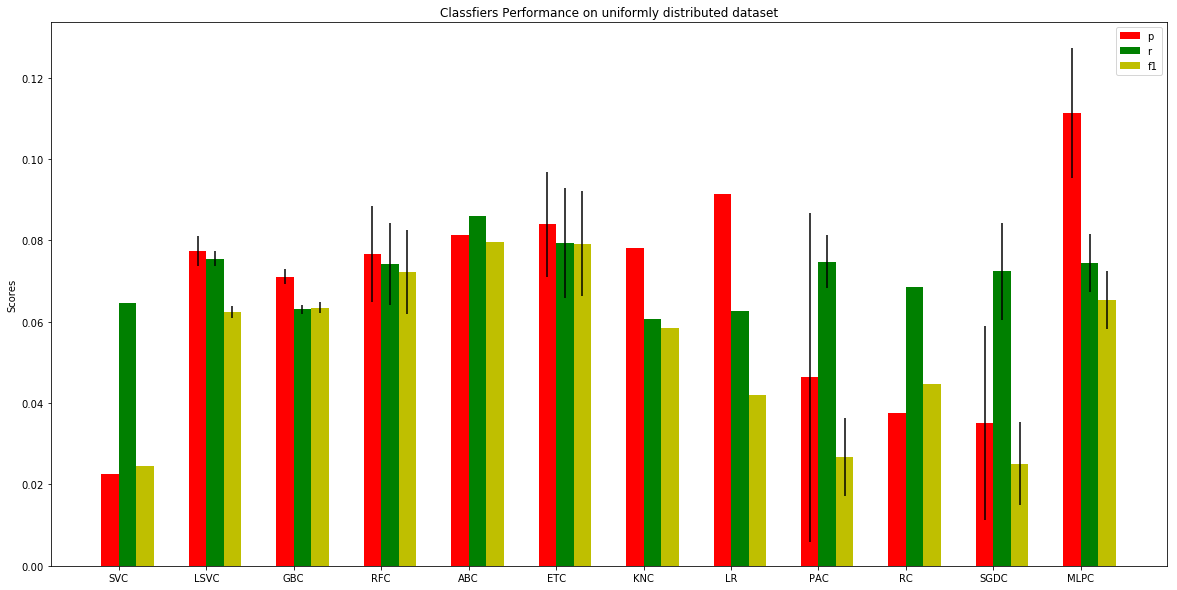

In [20]:
#Set training/test size:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.5, random_state=0)

methods=[SVC(),LinearSVC(),GradientBoostingClassifier(),RandomForestClassifier(),
         AdaBoostClassifier(),ExtraTreesClassifier(),KNeighborsClassifier(),
         LogisticRegression(),PassiveAggressiveClassifier(),RidgeClassifier(),
         SGDClassifier(),MLPClassifier()]
labels=['SVC','LSVC','GBC','RFC','ABC','ETC','KNC','LR','PAC','RC','SGDC','MLPC']

p_avg=[]
r_avg=[]
f1_avg=[]

#Show the classification report on the filtered data, and the learning curves on the filtered data, 
#shuffled data and the uniformly distributed 'fake' data:
 
for k in range(len(methods)):    
    
    clf = methods[k]
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print "\n"+str(methods[k])+":\n"
    print(metrics.classification_report(y_test, y_pred))
    
    precision, recall, f1_score, support = metrics.precision_recall_fscore_support(y_test, y_pred)
   
    average_precision = 0.0
    average_recall = 0.0
    average_f1_score = 0.0
    
    for l in range(len(precision)):
        average_precision += precision[l] * support[l] / np.sum(support)
        average_recall += recall[l] * support[l] / np.sum(support)
        average_f1_score += f1_score[l] * support[l] / np.sum(support)
    
    print(average_precision, average_recall, average_f1_score)
    
    p_avg.append(average_precision)
    r_avg.append(average_recall)
    f1_avg.append(average_f1_score)
    
    cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
    estimator = RandomForestClassifier(max_depth = 5)
    plot_learning_curve(estimator, "learning curve", X, y, (0, 1), cv=cv, n_jobs=4)
    plot_learning_curve(estimator, "learning curve on shuffled data", X, y_random, (0, 1), cv=cv, n_jobs=4)
    plot_learning_curve(estimator, "learning curve on uniformly distributed data", X, y_random2, (0, 1), cv=cv, n_jobs=4)
    plt.show()
    
#Run each classifiers for 10 times, and calculate the average and standard dev:
p = np.array(p_avg)
r = np.array(r_avg)
f1 = np.array(f1_avg)

classifier_avg_precision_matrix = np.zeros([12, 10])
classifier_avg_recall_matrix = np.zeros([12, 10])
classifier_avg_f1_score_matrix = np.zeros([12, 10])

Y = [y, y_random, y_random2]
graph_label = ['Classifiers Performance','Classifiers Performance on shuffled dataset',
               'Classfiers Performance on uniformly distributed dataset']
for j in range(len(Y)):
    X_train, X_test, y_train, y_test = train_test_split(
    X, Y[j], test_size=0.5, random_state=0)
    for run_number in range(10):
        for k in range(len(methods)):
            clf = methods[k]
            clf = clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)

            precision, recall, f1_score, support = metrics.precision_recall_fscore_support(y_test, y_pred)

            average_precision = 0.0
            average_recall = 0.0
            average_f1_score = 0.0

            for l in range(len(precision)):
                average_precision += precision[l] * support[l] / np.sum(support)
                average_recall += recall[l] * support[l] / np.sum(support)
                average_f1_score += f1_score[l] * support[l] / np.sum(support)

            classifier_avg_precision_matrix[k][run_number] = average_precision
            classifier_avg_recall_matrix[k][run_number] = average_recall
            classifier_avg_f1_score_matrix[k][run_number] = average_f1_score

    p_avg = np.mean(classifier_avg_precision_matrix, axis=1)
    r_avg = np.mean(classifier_avg_recall_matrix, axis=1)
    f1_avg = np.mean(classifier_avg_f1_score_matrix, axis=1)
    p_std = np.std(classifier_avg_precision_matrix, axis=1)
    r_std = np.std(classifier_avg_recall_matrix, axis=1)
    f1_std = np.std(classifier_avg_f1_score_matrix, axis=1)

    #Plot the histogram for precision, recall and f1-score for different classifiers:
    
    N = 12
    ind = np.arange(N)  
    width = 0.2       
    fig, ax = plt.subplots(figsize=(20,10))

    rects1 = ax.bar(ind, p_avg, width, color='r', yerr=p_std)
    rects2 = ax.bar(ind + width, r_avg, width, color='g', yerr=r_std)
    rects3 = ax.bar(ind + 2*width, f1_avg, width, color='y', yerr=f1_std)
   
    ax.set_ylabel('Scores')
    ax.set_title(graph_label[j])
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(labels)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('p', 'r', 'f1'))

    plt.show()


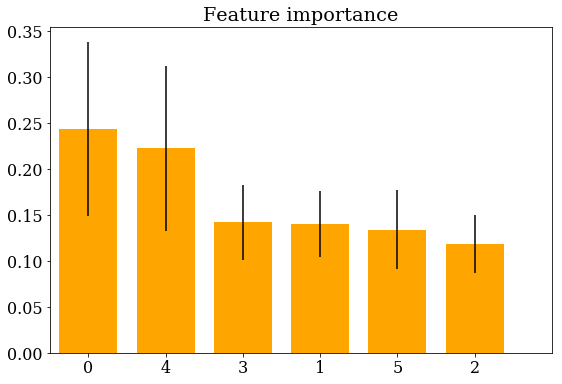

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.5, random_state=0)

#Plot feature importances:
clf = RandomForestClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
importances = clf.feature_importances_ #forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(9,6))
#matplotlib.rc('xtick', labelsize=10)
plt.rc('font', family='serif', size=16)
labels = np.array(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'])
plt.title("Feature importance")
xs = range(X_train.shape[1]*2)
plt.bar(xs[0::2], importances[indices],
        color="orange", yerr=std[indices], align="center", width=1.5)
plt.xticks(xs[0::2], labels[indices])
plt.xlim([-1, X_train.shape[1]*2])
plt.show()